## Pulse packet example
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/pulsepacket.html

### Reference
* Diesmann M. 2002. Dissertation. Conditions for stable propagation of synchronous spiking in cortical neural networks: Single neuron dynamics and network properties. http://d-nb.info/968772781/34.

In [1]:
import matplotlib.pyplot as plt
import nest
import numpy
import scipy.special as sp

[admin:1831831] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.admin.1000/jf.0/4020240384/shared_mem_cuda_pool.admin could be created.
[admin:1831831] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Oct  2 2024 11:54:50

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Properties of pulse packet:

a = 100  # number of spikes in one pulse packet
sdev = 10.0  # width of pulse packet (ms)
weight = 0.1  # PSP amplitude (mV)
pulsetime = 500.0  # occurrence time (center) of pulse-packet (ms)


# Network and neuron characteristics:

n_neurons = 100  # number of neurons
cm = 200.0  # membrane capacitance (pF)
tau_s = 0.5  # synaptic time constant (ms)
tau_m = 20.0  # membrane time constant (ms)
V0 = 0.0  # resting potential (mV)
Vth = numpy.inf  # firing threshold, high value to avoid spiking


# Simulation and analysis parameters:

simtime = 1000.0  # how long we simulate (ms)
simulation_resolution = 0.1  # (ms)
sampling_resolution = 1.0  # for voltmeter (ms)
convolution_resolution = 1.0  # for the analytics (ms)


# Some parameters in base units.

Cm = cm * 1e-12  # convert to Farad
Weight = weight * 1e-12  # convert to Ampere
Tau_s = tau_s * 1e-3  # convert to sec
Tau_m = tau_m * 1e-3  # convert to sec
Sdev = sdev * 1e-3  # convert to sec
Convolution_resolution = convolution_resolution * 1e-3  # convert to sec

* Time: a time array or a single time point (in sec)
* Tau_s and Tau_m: the synaptic and the membrane time constant (in sec)
* Cm: the membrane capacity (in Farad)
* Weight: the synaptic weight (in Ampere)

In [3]:
def make_psp(Time, Tau_s, Tau_m, Cm, Weight):
    term1 = 1 / Tau_s - 1 / Tau_m
    term2 = numpy.exp(-Time / Tau_s)
    term3 = numpy.exp(-Time / Tau_m)
    PSP = Weight / Cm * numpy.exp(1) / Tau_s * (((-Time * term2) / term1) + (term3 - term2) / term1**2)
    return PSP * 1e3

In [4]:
def LambertWm1(x):
    # Using scipy to mimic the gsl_sf_lambert_Wm1 function.
    return sp.lambertw(x, k=-1 if x < 0 else 0).real


def find_loc_pspmax(tau_s, tau_m):
    var = tau_m / tau_s
    lam = LambertWm1(-numpy.exp(-1 / var) / var)
    t_maxpsp = (-var * lam - 1) / var / (1 / tau_s - 1 / tau_m) * 1e-3
    return t_maxpsp

In [5]:
sig = Sdev
mu = 0.0
x = numpy.arange(-4 * sig, 4 * sig, Convolution_resolution)
term1 = 1 / (sig * numpy.sqrt(2 * numpy.pi))
term2 = numpy.exp(-((x - mu) ** 2) / (sig**2 * 2))
gauss = term1 * term2 * Convolution_resolution

In [6]:
t_psp = numpy.arange(0, 10 * (Tau_m + Tau_s), Convolution_resolution)
psp = make_psp(t_psp, Tau_s, Tau_m, Cm, Weight)

In [7]:
t_pspmax = find_loc_pspmax(Tau_s, Tau_m)
psp_amp = make_psp(t_pspmax, Tau_s, Tau_m, Cm, Weight)
psp_norm = psp / psp_amp

In [8]:
psp_norm = numpy.pad(psp_norm, [len(psp_norm) - 1, 1], mode="constant")
U = a * psp_amp * numpy.convolve(gauss, psp_norm)
ulen = len(U)
t_U = convolution_resolution * numpy.linspace(-ulen / 2.0, ulen / 2.0, ulen) + pulsetime + 1.0

In [9]:
nest.ResetKernel()
nest.set_verbosity("M_WARNING")
nest.resolution = simulation_resolution

In [10]:
neuron_pars = {"V_th": Vth, 
               "tau_m": tau_m, 
               "tau_syn_ex": tau_s, 
               "C_m": cm, 
               "E_L": V0, 
               "V_reset": V0, 
               "V_m": V0}
neurons = nest.Create("iaf_psc_alpha", n_neurons, neuron_pars)
ppg_pars = {"pulse_times": [pulsetime], "activity": a, "sdev": sdev}
ppgs = nest.Create("pulsepacket_generator", n_neurons, ppg_pars)
vm_pars = {"interval": sampling_resolution}
vm = nest.Create("voltmeter", params=vm_pars)

In [11]:
nest.Connect(ppgs, neurons, "one_to_one", syn_spec={"weight": weight})
nest.Connect(vm, neurons, syn_spec={"weight": weight})

In [12]:
nest.Simulate(simtime) # simtime = 1000.0 ms

In [13]:
Vm = vm.get("events", "V_m")
times = vm.get("events", "times")
senders = vm.get("events", "senders")

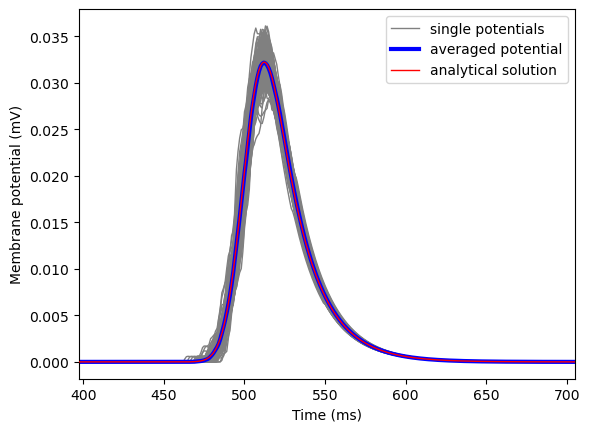

In [37]:

Vm_single = [Vm[senders == n.global_id] for n in neurons]
simtimes = numpy.arange(1, simtime)
for idn in range(n_neurons):
    if idn == 0:
        plt.plot(simtimes, Vm_single[idn], "gray", lw=1, zorder=1, label="single potentials")
    else:
        plt.plot(simtimes, Vm_single[idn], "gray", lw=1, zorder=1)

Vm_average = numpy.mean(Vm_single, axis=0)
plt.plot(simtimes, Vm_average, "b", lw=3, zorder=1, label="averaged potential")

plt.plot(t_U, U + V0, "r", lw=1, zorder=3, label="analytical solution")

plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.xlim((-5 * (tau_m + tau_s) + pulsetime, 10 * (tau_m + tau_s) + pulsetime))
plt.legend()
